In [2]:
words = open('names.txt', 'r').read().splitlines()

In [270]:
words[:3]

['emma', 'olivia', 'ava']

In [ ]:
import random

In [ ]:
# Convert the list to a PyTorch dataset (if not already a dataset)
random.seed(42)
words_shuffle = words.copy()
random.shuffle(words_shuffle)

# Calculate lengths for 80% train and 20% test
total_size = len(words_shuffle)
train_size = int(0.8 * total_size)
dev_size = int(0.1 * total_size)
test_size = total_size - train_size

# Perform the random split
train_words = words_shuffle[:train_size]
dev_words = words_shuffle[train_size:train_size+dev_size]
test_words = words_shuffle[train_size+dev_size:]

In [9]:
import torch

In [10]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [21]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [12]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

In [14]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [44]:
P = (N+1).float()
sum = P.sum(dim=1, keepdim=True)
P = P / sum

In [45]:
P.shape

torch.Size([27, 27])

In [46]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [62]:
# NOTE(kv) How likely is it that bigrams from an actual name appear in the dataset?

neg_log_likelihood = 0.

bigram_count = 0
for w in ['andrew']:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    neg_log_likelihood += -torch.log(prob).item()
    bigram_count += 1
    print(f'{ch1} {ch2}   {prob.item():.4f}')

neg_log_likelihood / bigram_count

. a   0.1376
a n   0.1604
n d   0.0384
d r   0.0770
r e   0.1334
e w   0.0025
w .   0.0544


2.9367679357528687

In [165]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [435]:
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-564996.8125, grad_fn=<AddBackward0>)
nll=tensor(564996.8125, grad_fn=<NegBackward0>)
2.476470470428467


In [67]:
# NOTE(kv) Create the training set of bigrams (x,y)
xs = []
ys = []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


In [72]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [488]:
xenc.shape

torch.Size([5, 27])

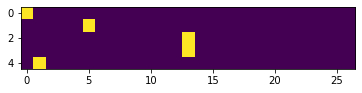

In [489]:
plt.imshow(xenc)

In [490]:
xenc.dtype

torch.float32

In [493]:
W = torch.randn((27, 1))
xenc @ W

tensor([[-0.2003, -2.3711, -0.9466,  0.5369, -0.0949, -1.7872, -0.9038,  0.8194,
          0.6926,  0.0114, -1.5301,  0.6077, -1.2056,  1.8605, -1.3012, -0.0301,
         -2.1611, -0.0538, -0.0133, -0.3629,  0.5254, -0.0080,  1.1602,  1.9851,
          0.4976,  0.7351, -0.6373],
        [-0.4422,  0.5024,  1.3514, -0.4085, -0.7854, -1.2568, -0.4558,  0.1466,
         -0.4460,  1.2748, -0.6367,  0.6403, -0.5617, -0.3060,  1.6771, -1.4814,
         -2.7395,  0.3876,  0.3970,  1.5577, -0.1995, -0.1397, -1.3045,  0.4294,
          1.2557,  0.8007,  0.5450],
        [-0.2680, -0.2640,  0.4591,  0.0338,  0.7478,  1.2757, -0.9842,  0.1799,
          0.0824, -0.5646, -0.3657, -0.8358, -1.7654,  0.5008, -1.7455, -0.8160,
         -2.2721,  0.9713, -1.0734,  0.3115, -0.2506,  0.0757,  0.9332,  1.6536,
          1.2306,  0.1231, -0.2530],
        [-0.2680, -0.2640,  0.4591,  0.0338,  0.7478,  1.2757, -0.9842,  0.1799,
          0.0824, -0.5646, -0.3657, -0.8358, -1.7654,  0.5008, -1.7455, -0.8160

In [506]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0205, 0.0023, 0.0097, 0.0428, 0.0228, 0.0042, 0.0101, 0.0568, 0.0500,
         0.0253, 0.0054, 0.0460, 0.0075, 0.1609, 0.0068, 0.0243, 0.0029, 0.0237,
         0.0247, 0.0174, 0.0423, 0.0248, 0.0799, 0.1822, 0.0412, 0.0522, 0.0132],
        [0.0154, 0.0397, 0.0928, 0.0160, 0.0110, 0.0068, 0.0152, 0.0278, 0.0154,
         0.0860, 0.0127, 0.0456, 0.0137, 0.0177, 0.1286, 0.0055, 0.0016, 0.0354,
         0.0357, 0.1141, 0.0197, 0.0209, 0.0065, 0.0369, 0.0844, 0.0535, 0.0414],
        [0.0212, 0.0213, 0.0439, 0.0287, 0.0586, 0.0994, 0.0104, 0.0332, 0.0301,
         0.0158, 0.0192, 0.0120, 0.0047, 0.0458, 0.0048, 0.0123, 0.0029, 0.0733,
         0.0095, 0.0379, 0.0216, 0.0299, 0.0705, 0.1450, 0.0950, 0.0314, 0.0215],
        [0.0212, 0.0213, 0.0439, 0.0287, 0.0586, 0.0994, 0.0104, 0.0332, 0.0301,
         0.0158, 0.0192, 0.0120, 0.0047, 0.0458, 0.0048, 0.0123, 0.0029, 0.0733,
         0.0095, 0.0379, 0.0216, 0.0299, 0.0705, 0.1450, 0.0950, 0.0314, 0.0215],
        [0.0289, 0.0077,

In [509]:
probs[0]

tensor([0.0205, 0.0023, 0.0097, 0.0428, 0.0228, 0.0042, 0.0101, 0.0568, 0.0500,
        0.0253, 0.0054, 0.0460, 0.0075, 0.1609, 0.0068, 0.0243, 0.0029, 0.0237,
        0.0247, 0.0174, 0.0423, 0.0248, 0.0799, 0.1822, 0.0412, 0.0522, 0.0132])

In [510]:
probs[0].shape

torch.Size([27])

In [507]:
probs[0].sum()

tensor(1.)

In [ ]:
# (5, 27) @ (27, 27) -> (5, 27)

In [ ]:
# SUMMARY ------------------------------>>>>

In [528]:
xs

tensor([ 0,  5, 13, 13,  1])

In [529]:
ys

tensor([ 5, 13, 13,  1,  0])

In [119]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [135]:
# Forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
sums = counts.sum(1, keepdims=True)
probs = counts / sums

In [136]:
label_likelihood = probs[torch.arange(5), ys]
log_likelihood = label_likelihood.log().mean()
loss = -log_likelihood

In [137]:
print(loss.item())

3.7091541290283203


In [138]:
# NOTE(kv) Backward pass
# STUDY(kv) I definitely don't understand this!
# Why do we only need to reset the gradident on 'W'?
W.grad = None
loss.backward()

In [139]:
W.data += -0.1 * W.grad

In [ ]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [285]:
# Create the dataset

def create_bigram_dataset(word_list):
    xs, ys = [], []
    
    for w in word_list:
      chs = ['.'] + list(w) + ['.']
      for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

train_xs, train_ys = create_bigram_dataset(train_words)
dev_xs, dev_ys     = create_bigram_dataset(dev_words)
test_xs, test_ys   = create_bigram_dataset(test_words)

In [359]:
def forward_pass(W, xs, ys, num_classes, regularization=0.):
  # forward pass
  # xenc = F.one_hot(inputs, num_classes=num_classes).float() # input to the network: one-hot encoding
  logits = W[xs] # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  regularizer = regularization * (W**2).mean()
  loss = -probs[torch.arange(len(xs)), ys].log().mean() + regularizer
  return loss

In [360]:
# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W_bigram = torch.randn((27, 27), generator=g, requires_grad=True)

In [361]:
# gradient descent
W = W_bigram

for k in range(100):
  
  loss = forward_pass(W, train_xs, train_ys, 27)
  if k % 10 == 0:
    print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

3.757847309112549
2.6887807846069336
2.572841167449951
2.5301930904388428
2.5086631774902344
2.4961068630218506
2.4880332946777344
2.482424020767212
2.4783003330230713
2.4751484394073486


In [362]:
forward_pass(W_bigram, dev_xs, dev_ys, 27)

tensor(2.4706, grad_fn=<AddBackward0>)

In [363]:
forward_pass(W_bigram, test_xs, test_ys, 27)

tensor(2.4771, grad_fn=<AddBackward0>)

In [364]:
# NOTE(kv) Generate the probability table

counts = W_bigram.exp()
P_bigram = counts / counts.sum(1, keepdims=True)

In [365]:
# NOTE(kv) Use our neural net to generate some stuff...

g = torch.Generator().manual_seed(2147483647)

for i in range(50):
  
  out = []
  ix = 0
  while True:
    p = P_bigram[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
pxzfay.
a.
nn.
kohin.
tolian.
juwe.
kalanaauranilevias.
dedainrwieta.
seiy.
elylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabi.
werimikimaynin.
anaasn.
ssorionszah.
dgossmitan.
il.
le.
pann.
that.
janreli.
isa.
dyn.
rijelujemahaunwyaleva.
cararr.
jenh.
anarta.
maly.
abely.
a.
i.
lavadoni.
themielyawat.
f.
modam.
tavilitikiesaloeverin.
n.
e.
kfabjanelah.
anen.
ch.
k.
jan.
odridrdze.


# We're doing trigram now!

In [366]:
# Create the dataset

def create_trigram_dataset(word_list):
    xs, ys = [], []
    
    for w in word_list:
      chs = ['.', '.'] + list(w) + ['.']
      for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append(ix1 * 27 + ix2)
        ys.append(ix3)

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

tri_train_xs, tri_train_ys = create_trigram_dataset(train_words)
tri_dev_xs, tri_dev_ys     = create_trigram_dataset(dev_words)
tri_test_xs, tri_test_ys   = create_trigram_dataset(test_words) 

## Trigram table-based approach

In [256]:
# Table-based approach
N = torch.zeros(27*27, 27)
for x,y in zip(xs, ys):
    N[x,y] += 1

In [258]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [251]:
import math

In [264]:
P[0]

tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
        1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
        4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
        5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
        4.2109e-03, 1.6719e-02, 2.9008e-02])

In [266]:
# NOTE(kv) Generate something with the table

g = torch.Generator().manual_seed(2147483647)

for i in range(10):
  
  out = []
  ix1 = 0
  ix2 = 0

  char_count = 0
  while True:
    p = P[ix1*27 + ix2]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if ix == 0:
      break
    out.append(itos[ix])
    ix1 = ix2
    ix2 = ix
    char_count += 1

  output_word = ''.join(out)
  print(f'{output_word}')

a
a
a
a
a
a
a
a
a
a


## Neural network trigram

In [367]:
# initialize the 'network'

g = torch.Generator().manual_seed(2147483647)
W_trigram = torch.randn((27*27, 27), generator=g, requires_grad=True)

In [371]:
# gradient descent
W = W_trigram

for k in range(100):  
  # forward pass
  loss = forward_pass(W, tri_train_xs, tri_train_ys, 27*27,
                      regularization=0)
  if k % 10 == 0:
    print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

3.184732675552368
2.861912488937378
2.7183754444122314
2.6345574855804443
2.5773909091949463
2.5350072383880615
2.501995801925659
2.4754135608673096
2.4534664154052734
2.434983968734741


In [372]:
# NOTE(kv) Test set
forward_pass(W_trigram, tri_test_xs, tri_test_ys, 27*27)

tensor(2.4256, grad_fn=<AddBackward0>)

NOTE(kv): 2.5139 is no regularization, evaluated on test
2.51 with reg=0.1
2.51 with 1.
3.1 with 100

In [373]:
# NOTE(kv) Generate the probability table

counts = W_trigram.exp()
P_trigram = counts / counts.sum(1, keepdims=True)

# NOTE(kv) Use our trigram neural net to generate some stuff...

P = P_trigram

g = torch.Generator().manual_seed(2147483647)

for i in range(50):
  
  out = []
  ix1 = 0
  ix2 = 0

  char_count = 0
  while True:
    p = P[ix1*27 + ix2]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if ix == 0:
      break
    out.append(itos[ix])
    ix1 = ix2
    ix2 = ix
    char_count += 1

  output_word = ''.join(out)
  print(f'output_word = {output_word}')

output_word = juwjdvdianaqaz
output_word = paufqywocnzqfjiir
output_word = tozcogsjgwzvudlhnpauyanilena
output_word = jadbduinrwibtlzsnjyiely
output_word = arte
output_word = faviumthyfodtumj
output_word = pfynslenhrjaylicora
output_word = yae
output_word = ocfkyjjabdiwejfmoifmwyn
output_word = na
output_word = gaasnhsvfihonszxhddgosfmptpacilz
output_word = rephufmthat
output_word = jayrsru
output_word = ish
output_word = dyn
output_word = rejekujcbkhvupwyhvpvhvccra
output_word = raydkhwfdztta
output_word = malyn
output_word = brlynn
output_word = iqzavmpocbzthemirayawathf
output_word = madxjxfpvslqtikizsalee
output_word = marlen
output_word = ewkfmbjzqegra
output_word = aneah
output_word = hwtmurzsodridcdznojvaliypvrghvxtezrwguciqqvywhqelv
output_word = emon
output_word = hamah
output_word = kellettmwbosenbzoiwupnwnpipixtewbgsgyewfdariccxrvjypkmsbrannjrdsydomarikdkbderihana
output_word = shdab
output_word = tauolwbasstegtte
output_word = keujfdtskceqjtcdlcndfrjqllippgkltalilokdmal
out